In [3]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import keras
#tf.compat.v1.disable_eager_execution()
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,RandomForestClassifier
import time
import datetime
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor,LGBMClassifier
from lightgbm import early_stopping
import optuna
from sklearn.metrics import log_loss, mean_squared_error, make_scorer,classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import cross_validate
from optuna.trial import TrialState
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import sklearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
import sys
#from gluonts.dataset.common import ListDataset
#from gluonts.dataset.field_names import FieldName
#from gluonts.model.deepar import DeepAREstimator
#from gluonts.trainer import Trainer

## Processing Dataset

In [4]:
sales_df = pd.read_csv("train.csv",dtype={'StateHoliday': 'S'})
store_df = pd.read_csv("store.csv")
store_df[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek']] = store_df[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek']].astype('Int64', errors='ignore')
store_df['CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(12)
store_df['CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(2099)
store_df['Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(51)
store_df['Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(2099)
df =  pd.merge(sales_df, store_df, how="left", on=["Store"])
df.head()
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(0)
df['CompetitiondateInt']=df['CompetitionOpenSinceYear'].astype(str) + df['CompetitionOpenSinceMonth'].astype(str).str.zfill(2)+ "01"
df['CompetitionDate'] = pd.to_datetime(df['CompetitiondateInt'], format='%Y%m%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['CompetitionDays'] = (df['Date'] - df['CompetitionDate']) / np.timedelta64(1, 'D')
df['CompetitionDays'][df['CompetitionDays'] < 0] = 0
df['Promo2DateInt'] = df.Promo2SinceYear*100+df.Promo2SinceWeek
df['Promo2Date'] = pd.to_datetime(df['Promo2DateInt'].astype(str) + '0', format='%Y%W%w')
df['Promo2Days'] = (df['Date'] - df['Promo2Date']) / np.timedelta64(1, 'D')
df.PromoInterval1 = pd.to_datetime(df.PromoInterval1, format='%b').dt.month
df.PromoInterval2 = pd.to_datetime(df.PromoInterval2, format='%b').dt.month
df.PromoInterval3 = pd.to_datetime(df.PromoInterval3, format='%b').dt.month
df.PromoInterval4 = pd.to_datetime(df.PromoInterval4, format='%b').dt.month
df['Promo2'] = np.logical_or(df['Date'].dt.month==df.PromoInterval1 , np.logical_or(df['Date'].dt.month==df.PromoInterval2 , np.logical_or(df['Date'].dt.month==df.PromoInterval3 , df['Date'].dt.month==df.PromoInterval4)))
df['Promo2'][df['Promo2Days'] < 0] = False
df['Promo2Days'][df['Promo2Days'] < 0] = 0
df['StateHoliday'] = pd.factorize(df['StateHoliday'])[0]
df['StoreType'] = pd.factorize(df['StoreType'])[0] + 1
df['Assortment'] = pd.factorize(df['Assortment'])[0] + 1
df['Promo2'] = pd.factorize(df['Promo2'])[0]
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df = df [df['Open'] == 1]
df = df.drop(['Open', 'Date','Customers','PromoInterval1','PromoInterval2','PromoInterval3','PromoInterval4','CompetitiondateInt','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionDate','Promo2SinceYear','Promo2SinceWeek','Promo2DateInt','Promo2Date'],axis=1)
df = df[['Store','Year','Month','Day','DayOfWeek','Promo','Promo2','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','CompetitionDays','Promo2Days','Sales']]
df = df.sort_values(by=['Year','Month','Day','Store'])
df.head()

C:\Users\danie\AppData\Local\Temp\ipykernel_15092\498478086.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CompetitionDays'][df['CompetitionDays'] < 0] = 0
C:\Users\danie\AppData\Local\Temp\ipykernel_15092\498478086.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo2'][df['Promo2Days'] < 0] = False
C:\Users\danie\AppData\Local\Temp\ipykernel_15092\498478086.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['

,Store,Year,Month,Day,DayOfWeek,Promo,Promo2,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionDays,Promo2Days,Sales
1016179,85,2013,1,1,2,0,0,1,1,4,1,1870,458.0,0.0,4220
1016353,259,2013,1,1,2,0,0,1,1,4,3,210,0.0,0.0,6851
1016356,262,2013,1,1,2,0,0,1,1,4,1,1180,0.0,0.0,17267
1016368,274,2013,1,1,2,0,0,1,1,4,3,3640,0.0,0.0,3102
1016429,335,2013,1,1,2,0,0,1,1,4,1,90,0.0,0.0,2401


## Processing Model Input

In [5]:
def LGBM_input(df,n_steps_in,fcst_step,store_id=None):
    if store_id is None:
        df_out = df.copy()
    else:
        df_out = df[df['Store']==store_id].copy()
    for i in range(1,n_steps_in+1):
            df_out['lag'+str(i)] = df['Sales'].shift(i+fcst_step-1)
    cols = list(df_out.columns.values) 
    cols.pop(cols.index('Sales')) 
    df_out = df_out[cols+['Sales']]
    return df_out.iloc[n_steps_in+fcst_step:,:]

def DeepAR_input(df,test_split):
    deepar_df = df[['Store','Year','Month','Day','Sales']]
    deepar_df['Date'] = pd.to_datetime((deepar_df.values[:,1]*10000+deepar_df.values[:,2]*100+deepar_df.values[:,3]).astype(str)).values.astype('datetime64[D]')
    deepar_df = deepar_df[['Store','Date','Sales']]
    deepar_df = deepar_df.pivot(index='Store',columns='Date',values='Sales')
    deepar_df = deepar_df.fillna(0)
    test_len = math.floor(deepar_df.shape[1] * test_split)
    store = deepar_df.index
    dat = deepar_df.values
    train_ar = dat[:,:test_len]
    test_ar = dat[:,test_len:]
    return train_ar,test_ar

def LSTM_input(df,store_id,n_steps_in,fcst_step):
    df_out = df[df['Store']==store_id].copy()
    X_col=[]
    Y_col=[]
    for i in range(1,n_steps_in+1):
        X_col=['lag'+str(i)]+X_col
        df_out['lag'+str(i)] = df_out['Sales'].shift(i)
    Y_col += ['Sales']
    for i in range(1,fcst_step):
        df_out['fcst'+str(i)] = df_out['Sales'].shift(-i)
        Y_col += ['fcst'+str(i)]
    train_X = df_out[X_col].iloc[n_steps_in:-fcst_step+1,:].values
    train_X = np.reshape(train_X, (train_X.shape[0],train_X.shape[1], 1 ))
    train_Y = df_out[Y_col].iloc[n_steps_in:-fcst_step+1,:].values
    train_Y = np.reshape(train_Y, (train_Y.shape[0],train_Y.shape[1], 1 ))
    return train_X,train_Y


## Optuna Model Tuning

In [27]:
from optuna.integration import LightGBMPruningCallback
from optuna.integration import TFKerasPruningCallback

def objective_LGBM(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int('n_estimators', 200, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 50, step=2),
        "max_depth": trial.suggest_int("max_depth", 1, 5),
        #"min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        #"lambda_l1": trial.suggest_int("lambda_l1", 0, 20, step=1),
        #"lambda_l2": trial.suggest_int("lambda_l2", 0, 20, step=1),
        #"min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 5),
    }

    lgbm_reg = LGBMRegressor(**param_grid)
    scores = cross_validate(lgbm_reg, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    rmse = np.sqrt(-scores["test_score"].mean())
    return rmse

def objective_RF(trial, X, y):
    param_grid = {
        #"device_type": trial.suggest_categorical("device_type", ['gpu']),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15)
    }

    lgbm_reg = RandomForestRegressor(**param_grid)
    scores = cross_validate(lgbm_reg, X, y, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    rmse = np.sqrt(-scores["test_score"].mean())
    return rmse

def objective_LGBM_Classifier(trial, X, y):
    param_grid = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        'num_class': 7,
        "n_estimators": trial.suggest_int('n_estimators', 50, 500),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 500),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # LGBM modeling
        model = LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            verbose= False,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            callbacks=[early_stopping(stopping_rounds=10)]
        )
        # model prediction 
        preds = model.predict_proba(X_test)
        # Optimization index logloss minimum
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

def create_model(trial, n_steps_in, n_steps_out):
    # We optimize the numbers of layers, their units, dropouts and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 0, 2)
    weight_decay = trial.suggest_float("weight_decay",  2e-6, 1e-1, log=True)
    model = Sequential()
    dropout = trial.suggest_float("dropout_l{}".format(0), 0, 0.2)
    num_hidden = trial.suggest_int("n_units_l{}".format(0), 5, 100)
    if n_layers > 0:
        model.add(LSTM(num_hidden, input_shape=(n_steps_in, 1), return_sequences=True, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    else:
        model.add(LSTM(num_hidden, input_shape=(n_steps_in, 1), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(Dropout(rate=dropout)) 
    for i in range(n_layers):
        dropout = trial.suggest_float("dropout_l{}".format(i+1), 0, 0.2)
        num_hidden = trial.suggest_int("n_units_l{}".format(i+1), 5, 100)
        if i == n_layers - 1:
            model.add(LSTM(num_hidden, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        else:
            model.add(LSTM(num_hidden, return_sequences=True, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
        model.add(Dropout(rate=dropout)) 
    model.add(Dense(n_steps_out, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['MeanSquaredError'],
    )
    print(model.summary())
    return model


def objective_lstm(trial, X, Y, n_steps_in, n_steps_out):
    keras.backend.clear_session()
    model = create_model(trial, n_steps_in, n_steps_out)
    split = math.floor(len(X) * 0.8)
    train_x, train_y = X[:split], Y[:split]
    validation_x, validation_y = X[split:], Y[split:]
    print(train_x.shape,train_y.shape)
    # Train model.
    history = model.fit(
        train_x, train_y,
        batch_size=128,
        epochs=20,
        validation_data=(validation_x, validation_y),
        callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        TFKerasPruningCallback(trial, 'val_loss'),],
)

    return history.history['val_loss'][-1]

def show_result(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


## Model Training

In [31]:
# Model & Evaluation
def train_LSTM(X,Y,n_steps_in,n_steps_out):
    # Initializing LTSM Model
    lstm_model = Sequential()
    weight_decay = 1.1080917986635159e-05
    lstm_model.add(LSTM(90, input_shape=(n_steps_in, 1), activation="relu", kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    lstm_model.add(Dropout(rate=0.09067366185204523)) 
    lstm_model.add(Dense(n_steps_out,kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X, Y, epochs=20, verbose=0)
    return lstm_model

def train_LSTM_Optuna(X, Y, n_steps_in, n_steps_out):
    study = optuna.create_study(direction="minimize", study_name="LSTM", pruner=optuna.pruners.MedianPruner(n_startup_trials=2))
    func = lambda trial: objective_lstm(trial, X, Y, n_steps_in, n_steps_out)
    study.optimize(func, n_trials=100 , timeout=6000)
    show_result(study)

def train_LGBM(X,Y):
    study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
    func = lambda trial: objective_LGBM(trial, X, Y)
    study.optimize(func, n_trials=200)
    parameters = study.best_params
    print(parameters)
    lgbm = LGBMRegressor(**parameters)
    lgbm.fit(X, Y)
    return lgbm

def train_RF(X,Y):
    study = optuna.create_study(direction="minimize", study_name="RF Regressor")
    func = lambda trial: objective_RF(trial, X, Y)
    study.optimize(func, n_trials=20)
    parameters = study.best_params
    print(parameters)
    rf = RandomForestRegressor(**parameters)
    rf.fit(X, Y)
    return rf

def train_LGBM_Classifier(X,Y):
    study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
    func = lambda trial: objective_LGBM_Classifier(trial, X, Y)
    study.optimize(func, n_trials=20)
    parameters = study.best_params
    print(parameters)
    lgbm = LGBMClassifier(**parameters)
    lgbm.fit(X, Y)
    return lgbm

def train_LGBM_Classifier2(X,Y):
    param_grid = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        'num_class': 7,
        "n_estimators": 1000
    }
    lgbm = LGBMClassifier(**param_grid)
    lgbm.fit(X, Y)
    return lgbm

def train_RF_Classifier2(X,Y):
    param_grid = {
        "n_estimators": 1000
    }
    rf = RandomForestClassifier(**param_grid)
    rf.fit(X, Y)
    return rf

def train_RF2(X,Y):
    param_grid = {'n_estimators': 535, 'max_depth': 10, 'min_samples_split': 2}
    rf = RandomForestRegressor(**param_grid)
    rf.fit(X, Y)
    return rf

def train_LGBM_Classifier2(X,Y):
    param_grid = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        'num_class': 7,
        "n_estimators": 1000
    }
    lgbm = LGBMClassifier(**param_grid)
    lgbm.fit(X, Y)
    return lgbm

def train_LGBM2(X,Y):
    parameters = {'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
    print(parameters)
    lgbm = LGBMRegressor(**parameters)
    lgbm.fit(X, Y)
    return lgbm


def train_LR(X,Y):
    model = LinearRegression()
    model.fit(X, Y)
    return model

def predict_multistep_LGBM(df,n_steps_in, n_steps_out):
    start = 0
    end = math.floor(len(df) * 0.9)
    test_length = math.floor((len(df) - math.floor(len(df) * 0.9)))
    output = np.zeros((test_length-24, n_steps_out))
    for i in range(n_steps_out):
        df['MT_320_lag']=df['MT_320'].shift(i)
        df['MT_320_lag'].fillna(df['MT_320_lag'].loc[df['MT_320_lag'].first_valid_index()], inplace=True)
        X_LGBM,Y_LGBM = prep_data(df, 'MT_320_lag', start, end, n_steps_in, n_steps_out)[2:4]
        testX_LGBM,testY_LGBM =  prep_data(df, 'MT_320_lag', end, end + test_length, n_steps_in, n_steps_out)[2:4]
        lgbm_model = train_LGBM(X_LGBM,Y_LGBM)
        pred = lgbm_model.predict(testX_LGBM)
        output[:,i] = pred
    return output[::n_steps_out].ravel()

def predict_multistep_LR(df,test_len,n_steps_in, n_steps_out):
    start = 0
    end = math.floor(len(df) * 0.9)
    output = np.zeros((test_len, n_steps_out))
    for i in range(n_steps_out):
        df['MT_320_lag']=df['MT_320'].shift(i)
        df['MT_320_lag'].fillna(df['MT_320_lag'].loc[df['MT_320_lag'].first_valid_index()], inplace=True)
        X_LR = df.iloc[start:end,2:].values
        Y_LR = df.iloc[start:end,1].values
        test_X_LR = df.iloc[end:end+test_len,2:].values
        lr_model = train_LR(X_LR,Y_LR)
        pred = lr_model.predict(test_X_LR)
        output[:,i] = pred
    return output[::n_steps_out].ravel()

In [8]:
def tuning_LSTM(df,store_id,steps_in,steps_out,test_size):
    start = 0
    end = math.floor(len(df) * test_size)
    test_length = math.floor((len(df) - math.floor(len(df) * test_size)))
    X,Y=LSTM_input(df.iloc[start:end,:],store_id,steps_in,steps_out)
    train_LSTM_Optuna(X,Y,steps_in,steps_out)

## Model Evaluation

In [9]:
def _nrmse(y_pred, target):
    mse = np.mean((y_pred - target)**2)
    rmse = np.sqrt(mse)
    denominator = np.mean(target)
    return rmse / denominator

def _nd(y_pred, target):
    nominator = np.sum(np.abs(y_pred - target))
    denominator = np.sum(np.abs(target))
    return nominator / denominator

In [32]:
def run_forecasting(df,n_steps_in, n_steps_out,store_id):
    
    # Train/Test Split and Definition
    input_df = LGBM_input(df,n_steps_in, n_steps_out,store_id)
    X = input_df.iloc[:,:-1].values
    y = input_df.iloc[:,-1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train the model and predict output
    lgbm_model = train_LGBM2(X_train,y_train)
    predict_LGBM = lgbm_model.predict(X_test)
    lr_model = train_LR(X_train,y_train)
    predict_LR = lr_model.predict(X_test)
    rf_model = train_RF2(X_train,y_train)
    predict_RF = rf_model.predict(X_test)
    # Aggregate predicted + baseline data and reverse scaler
    test_df = pd.DataFrame()
    test_df['Actual'] = y_test
    test_df['Store'] = X_test[:,0]
    test_df['Date'] = pd.to_datetime((X_test[:,1]*10000+X_test[:,2]*100+X_test[:,3]).astype(str)).values.astype('datetime64[D]')
    test_df['Predicted LGBM'] = predict_LGBM[0:len(test_df['Actual'])]
    test_df['Predicted RF'] = predict_RF[0:len(test_df['Actual'])]
    test_df['Predicted LR'] = predict_LR[0:len(test_df['Actual'])]
    test_df['Batch'] = np.floor(np.array(test_df.index) / n_steps_out)
    test_df = test_df[['Store','Date','Actual','Predicted LGBM','Predicted LR','Predicted RF']]
    return test_df

In [33]:
model_output = run_forecasting(df,10, 1,1007)
model_output.to_csv("Optuna_all_Data_LGBM.csv", index=False)

{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}


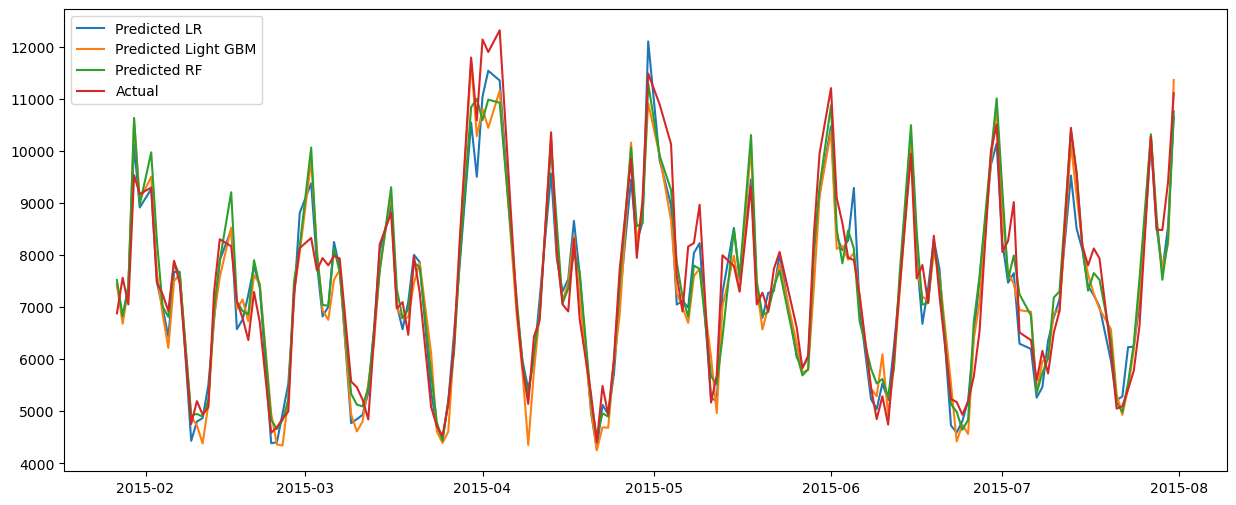

In [118]:
#Plot prediction and actual
fig1, ax1 = plt.subplots(figsize=(15, 6))
plt.plot(model_output[model_output['Store']==1007]['Date'], model_output[model_output['Store']==1007]['Predicted LR'], label='Predicted LR')
plt.plot(model_output[model_output['Store']==1007]['Date'], model_output[model_output['Store']==1007]['Predicted LGBM'], label='Predicted Light GBM')
plt.plot(model_output[model_output['Store']==1007]['Date'], model_output[model_output['Store']==1007]['Predicted RF'], label='Predicted RF')
plt.plot(model_output[model_output['Store']==1007]['Date'], model_output[model_output['Store']==1007]['Actual'], label='Actual')
plt.legend()
plt.savefig('regression.png')

In [190]:
def ML_Grocery(df, n_steps_in, test_len, inventory_cap, reg_cost, reg_order_delay, reserve, em_factor, order_threshold,em_order_threshold, back_order_cost,store_id,EO_MARGIN,PO_MARGIN):
    # TrainOneStepForecastModel(DF)
    input_df = LGBM_input(df,n_steps_in, 1,store_id)
    LGBM_X = input_df.iloc[:,:-1].values
    LGBM_y = input_df.iloc[:,-1].values
    LGBM_X_train, LGBM_X_test, LGBM_y_train, LGBM_y_test = train_test_split(LGBM_X, LGBM_y, test_size=test_len, shuffle=False)
    lgbm_model = train_LGBM2(LGBM_X_train,LGBM_y_train)
    # TrainMultiStepForecastModel(DF, D)
    Multi_Model = [lgbm_model]
    for i in range(2,reg_order_delay+reserve+2):
        input_df_multi = LGBM_input(df,n_steps_in, i,store_id)
        LGBM_X_multi = input_df_multi.iloc[:,:-1].values
        LGBM_y_multi = input_df_multi.iloc[:,-1].values
        LGBM_X_train_multi, LGBM_X_test_multi, LGBM_y_train_multi, LGBM_y_test_multi = train_test_split(LGBM_X_multi, LGBM_y_multi, test_size=test_len, shuffle=False)
        Multi_Model += [train_LGBM2(LGBM_X_train_multi,LGBM_y_train_multi)]
    
    inv = np.zeros(test_len+1)
    inv[0] = inventory_cap #Full inventory at beginning
    Delivery_Remain = 0
    Order_Amount = 0
    pre_Order = np.zeros(test_len)
    em_Order = np.zeros(test_len)
    Sales = LGBM_y_test
    cost = np.zeros(test_len)
    order_cost = 0
    overstock_cost = 0
    profit = np.zeros(test_len)
    acc_profit = np.zeros(test_len)
    cost[0] = 0.8
    store_close = 0
    overstock = 0
    closed = 0
    po_count = 0
    eo_count = 0
    po_sum = 0
    eo_sum = 0
    for i in range(test_len):
        if i != 0:
            inv[i] = inv[i-1] + em_Order[i-1] + pre_Order[i-reg_order_delay-1] - min(Sales[i-1],inv[i-1])
            if inv[i] > inventory_cap:
                inv[i] = inventory_cap
                overstock_cost = 500
                overstock += 1
            else:
                overstock_cost = 0
                
            if inv[i] < Sales[i]:
                store_close = 1000
                closed += 1
            else:
                store_close = 0    
            cost[i] = (inv[i-1] * cost[i-1] - min(Sales[i-1],inv[i-1]) * cost[i-1] +\
                    max(min(inventory_cap - (inv[i-1] - min(Sales[i-1],inv[i-1])) - pre_Order[i-reg_order_delay-1], em_Order[i-1]),0) * EO_MARGIN +\
                    max(min(inventory_cap - (inv[i-1] - min(Sales[i-1],inv[i-1])), pre_Order[i-reg_order_delay-1]),0) * PO_MARGIN) / max(inv[i], 0.01)
        
        single_Demands = lgbm_model.predict([LGBM_X_test[i]])[0]
        if single_Demands * em_factor > inv[i] + pre_Order[i-reg_order_delay] - min(Sales[i],inv[i]):
            em_Order[i] = single_Demands * em_factor - inv[i] - pre_Order[i-reg_order_delay] + min(Sales[i],inv[i])
            eo_count += 1
            if em_Order[i] < em_order_threshold:
                em_Order[i] = 0 # To save delivery cost
                eo_count -= 1
            eo_sum += em_Order[i]
        multi_Demands = np.array([Multi_Model[k].predict([LGBM_X_test[i]]) for k in range(len(Multi_Model))]).flatten()
        if sum(multi_Demands) > inv[i] + sum(pre_Order[max(i-reg_order_delay,0):i]) + em_Order[i] - min(Sales[i],inv[i]):
            pre_Order[i] = min(sum(multi_Demands) - inv[i] - sum(pre_Order[max(i-reg_order_delay,0):i]) - em_Order[i] + min(Sales[i],inv[i]),40000)
            po_count += 1
            if pre_Order[i] < order_threshold:
                pre_Order[i] = 0 # To save delivery cost
                po_count -= 1
            po_sum += pre_Order[i]
        if em_Order[i] != 0 or pre_Order[i] != 0:
            order_cost = 500
        else:
            order_cost = 0
        profit[i] = min(Sales[i], inv[i]) * (1 - cost[i]) - order_cost - overstock_cost - store_close
        acc_profit[i] = acc_profit[i-1] + profit[i]
        print(inv[i],Sales[i],em_Order[i],pre_Order[i],single_Demands,sum(multi_Demands),cost[i],profit[i],overstock,closed,po_count,eo_count,po_sum,eo_sum)
    return inv,pre_Order,em_Order,Sales,cost,profit,acc_profit

In [195]:
inv,pre_Order,em_Order,Sales,Cost,profit,acc_profit = ML_Grocery(df, 10, 150, 40000, 0.8, 7, 3,1.3, 12000, 2000, 0.95,1007,0.9,0.8)
print(sum(profit),sum(Sales))

{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 'num_leaves': 36, 'max_depth': 2}
{'n_estimators': 344, 'learning_rate': 0.09390455967232954, 

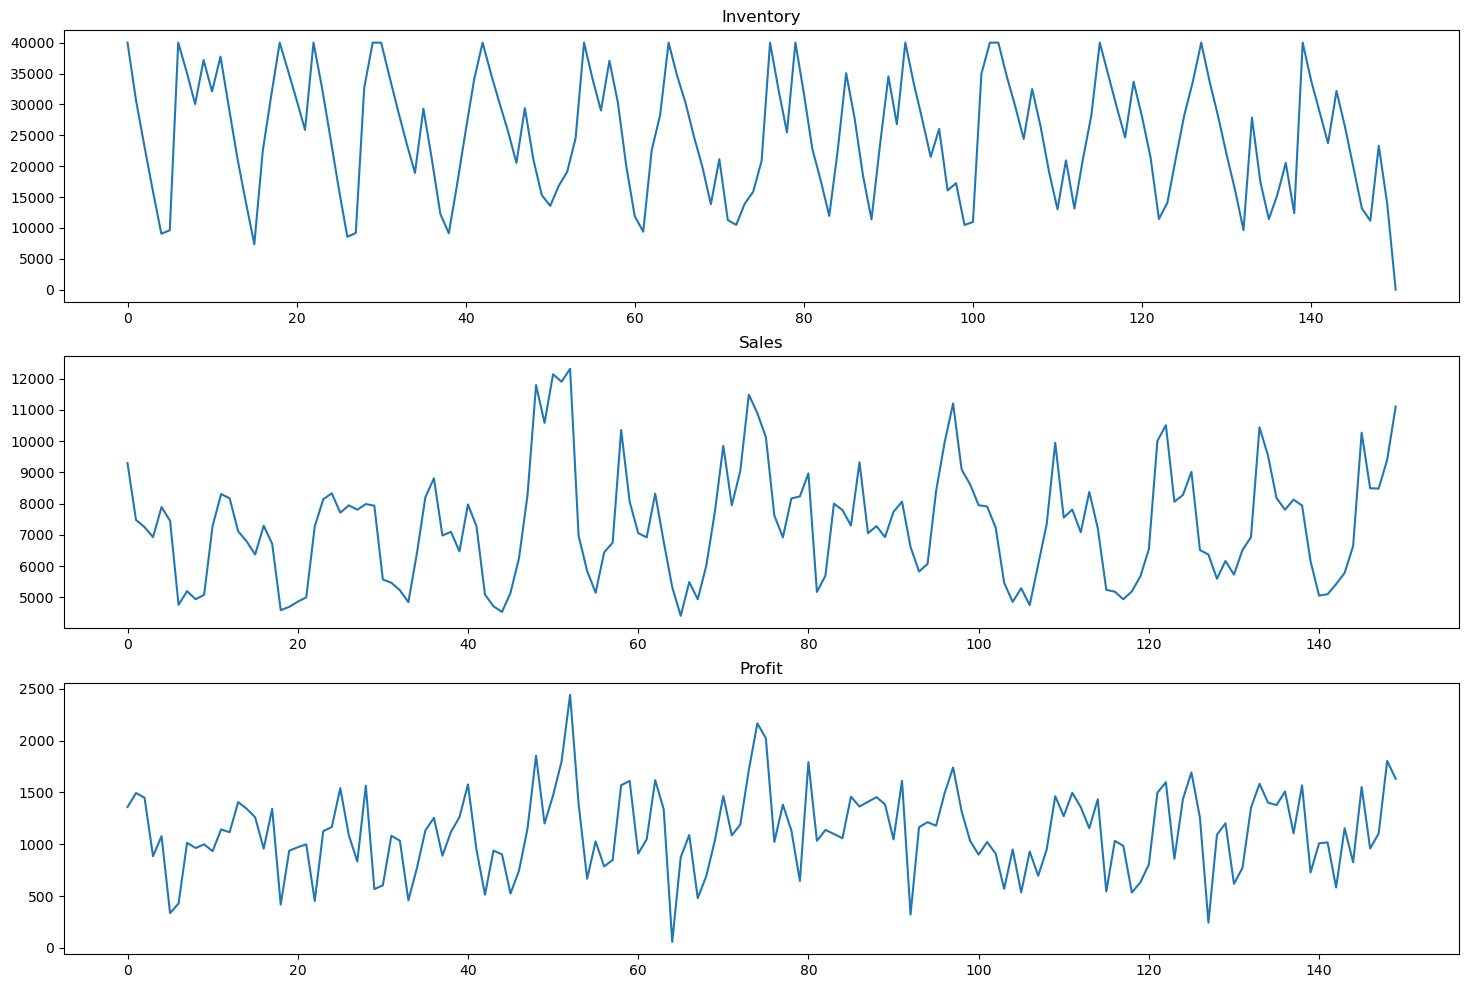

In [153]:
fig, ax = plt.subplots(3,1,figsize=(18,12))
ax[0].plot(inv,label='Inventory')
ax[1].plot(Sales,label='Sales')
ax[2].plot(profit,label='Profit')
ax[0].title.set_text('Inventory')
ax[1].title.set_text('Sales')
ax[2].title.set_text('Profit')
plt.show()

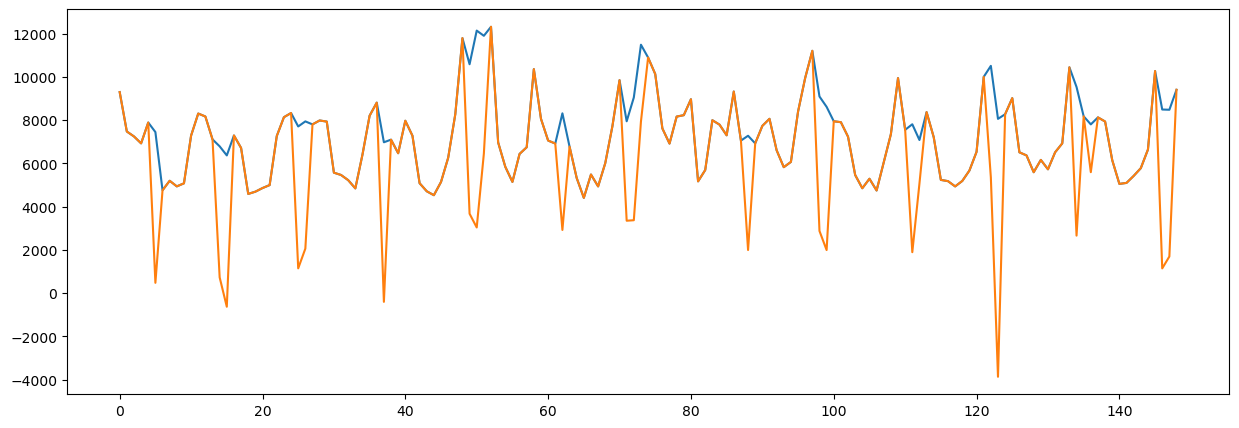

In [43]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(Sales[:-1])
plt.plot(Sales[:-1]-np.roll(em_Order,1)[:-1])

In [198]:
def BL_Grocery(df, n_steps_in, test_len, inventory_cap, reg_cost, reg_order_delay, reserve, order_threshold,em_order_threshold, back_order_cost,store_id,EO_MARGIN,PO_MARGIN):
    factor = 1.1
    # TrainOneStepForecastModel(DF)
    input_df = LGBM_input(df,n_steps_in, 1,store_id)
    LGBM_X = input_df.iloc[:,:-1].values
    LGBM_y = input_df.iloc[:,-1].values
    LGBM_X_train, LGBM_X_test, LGBM_y_train, LGBM_y_test = train_test_split(LGBM_X, LGBM_y, test_size=test_len, shuffle=False)
    inv = np.zeros(test_len+1)
    inv[0] = inventory_cap #Full inventory at beginning
    Delivery_Remain = 0
    Order_Amount = 0
    pre_Order = np.zeros(test_len)
    em_Order = np.zeros(test_len)
    Sales = LGBM_y_test
    cost = np.zeros(test_len)
    order_cost = 0
    overstock_cost = 0
    profit = np.zeros(test_len)
    acc_profit = np.zeros(test_len)
    cost[0] = 0.8
    store_close = 0
    month = LGBM_X_test[:,2]
    overstock = 0
    closed = 0
    po_count = 0
    eo_count = 0
    po_sum = 0
    eo_sum = 0
    avg_sales = [6543.8,6545.7,6983.9,6961.41,6815.02,6503.61,6620.69,7265.94,6519.45,6421.27,7248.37,9179.67]
    for i in range(test_len):
        if i != 0:
            inv[i] = inv[i-1] + em_Order[i-1] + pre_Order[i-reg_order_delay-1] - min(Sales[i-1],inv[i-1])
            if inv[i] > inventory_cap:
                inv[i] = inventory_cap
                overstock_cost = 500
                overstock += 1
            else:
                overstock_cost = 0
            if inv[i] < Sales[i]:
                store_close = 1000
                closed += 1
            else:
                store_close = 0
            
            cost[i] = (inv[i-1] * cost[i-1] - min(Sales[i-1],inv[i-1]) * cost[i-1] +\
                    max(min(inventory_cap - (inv[i-1] - min(Sales[i-1],inv[i-1])) - pre_Order[i-reg_order_delay-1], em_Order[i-1]),0) * EO_MARGIN +\
                    max(min(inventory_cap - (inv[i-1] - min(Sales[i-1],inv[i-1])), pre_Order[i-reg_order_delay-1]),0) * PO_MARGIN) / max(inv[i], 0.01)
        
        if inv[i] < em_order_threshold:
            em_Order[i] = avg_sales[month[i]-1]
            eo_count += 1
            eo_sum += em_Order[i]
        if sum(pre_Order[max(i-reg_order_delay,0):i]) == 0:
            pre_Order[i] = avg_sales[month[i]-1] * (reg_order_delay)
            po_count += 1
            po_sum += pre_Order[i]
        if em_Order[i] != 0 or pre_Order[i] != 0:
            order_cost = 500
        else:
            order_cost = 0
        profit[i] = min(Sales[i], inv[i]) * (1 - cost[i]) - order_cost - overstock_cost - store_close
        acc_profit[i] = acc_profit[i-1] + profit[i]
        print(inv[i],Sales[i],em_Order[i],pre_Order[i],cost[i],profit[i],overstock,closed,po_count,eo_count,po_sum,eo_sum)
    return inv,pre_Order,em_Order,Sales,cost,profit,acc_profit

In [199]:
inv,pre_Order,em_Order,Sales,Cost,profit,acc_profit = BL_Grocery(df, 10, 150, 40000, 0.8, 5, 1, 3000, 5000, 0.95,1007,0.9,0.8)
sum(profit)

40000.0 9296 0.0 32728.5 0.8 1359.1999999999996 0 0 1 0 32728.5 0
30704.0 7473 0.0 0.0 0.8 1494.5999999999997 0 0 1 0 32728.5 0
23231.0 7245 0.0 0.0 0.7999999999999999 1449.0000000000005 0 0 1 0 32728.5 0
15986.0 6925 0.0 0.0 0.7999999999999999 1385.0000000000005 0 0 1 0 32728.5 0
9061.0 7889 0.0 0.0 0.8 1577.7999999999997 0 0 1 0 32728.5 0
1172.0 7447 6545.7 0.0 0.7999999999999995 -1265.5999999999995 0 1 1 1 32728.5 6545.7
39274.2 4755 0.0 32728.5 0.8166666666666669 371.749999999999 0 1 2 1 65457.0 6545.7
34519.2 5194 0.0 0.0 0.816666666666667 952.2333333333316 0 1 2 1 65457.0 6545.7
29325.199999999997 4935 0.0 0.0 0.8166666666666669 904.749999999999 0 1 2 1 65457.0 6545.7
24390.199999999997 5076 0.0 0.0 0.816666666666667 930.5999999999984 0 1 2 1 65457.0 6545.7
19314.199999999997 7284 0.0 0.0 0.816666666666667 1335.3999999999976 0 1 2 1 65457.0 6545.7
12030.199999999997 8304 0.0 0.0 0.8166666666666671 1522.3999999999965 0 1 2 1 65457.0 6545.7
36454.7 8167 0.0 32728.5 0.80170357548775

124194.35599999991

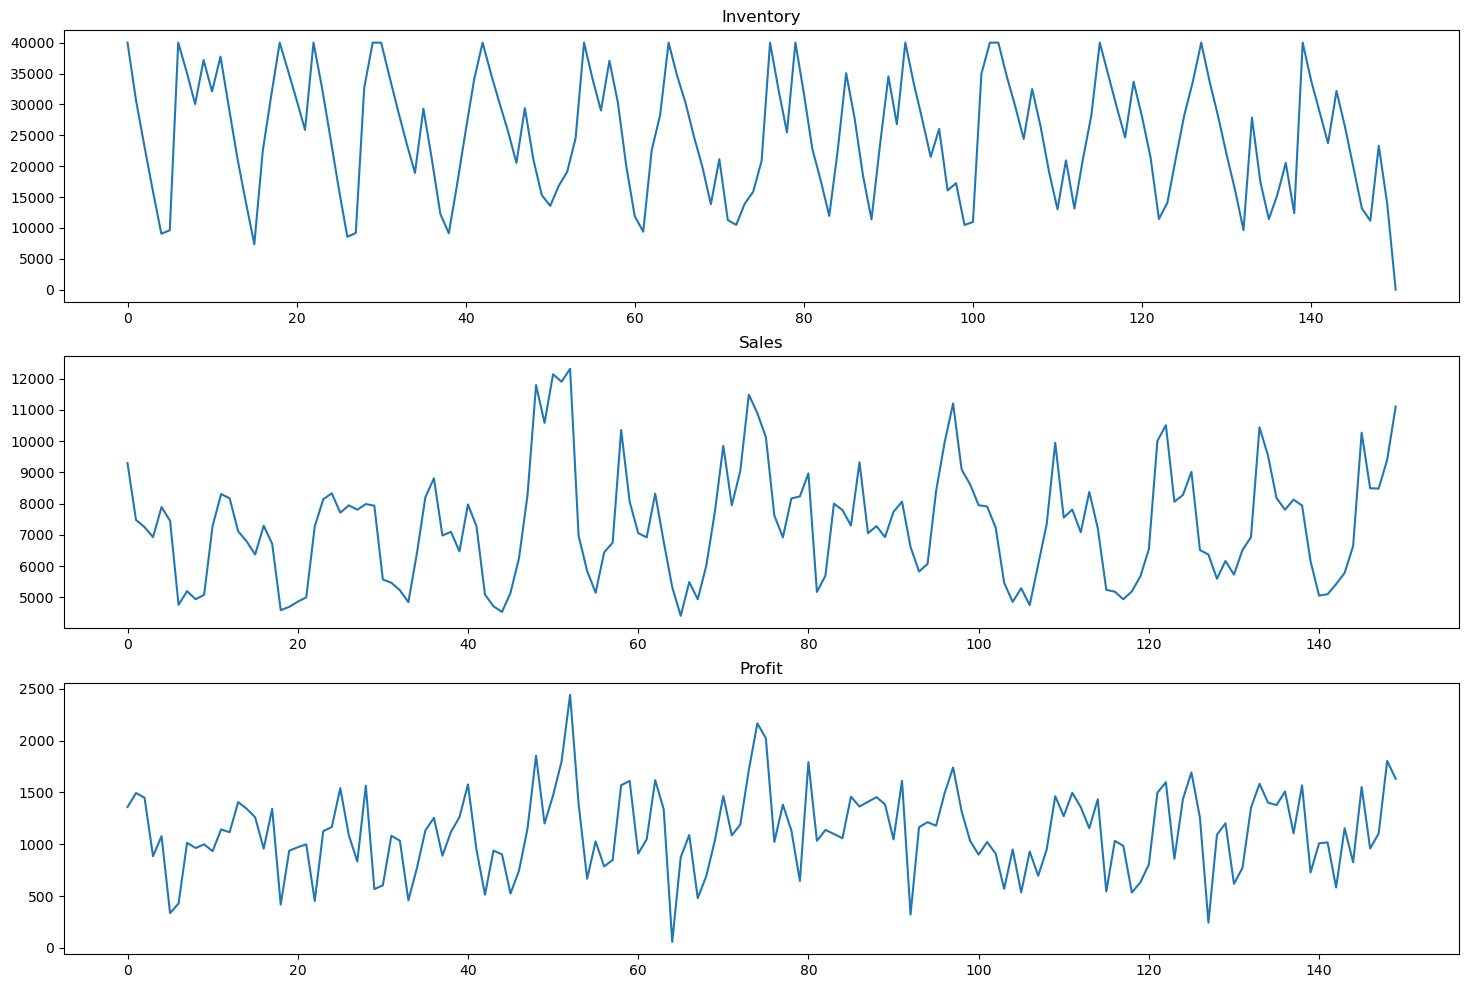

In [154]:
fig, ax = plt.subplots(3,1,figsize=(18,12))
ax[0].plot(inv,label='Inventory')
ax[1].plot(Sales,label='Sales')
ax[2].plot(profit,label='Profit')
ax[0].title.set_text('Inventory')
ax[1].title.set_text('Sales')
ax[2].title.set_text('Profit')
plt.savefig('Supervised.png')